# Investment and Trading Project

## Stock Predicton Project Definition

### Project Overview

This is an attempt to predict the stock prices using historical data and applies to the investment and trading domain.
While there are multiple factors that can affect stock pricing – economic, political, social etc., we will
use only the past stock prices themselves to solve a classification problem (buy or sell) or a regression problem (close price). My main motivation for this project is to learn how to effectively solve a time-series problem with a LSTM as the neural network. There have been multiple works in academia that incorporate Recurrent Neural Networks (RNN)and specifically Long Short Term Memory (LSTM) Neural nets for stock market prediction. [1] is an interesting paper where the authors have used different networks to derive useful stats about the stock but finally rely on LSTM to do the prediction. [2] is another paper where LSTM was employed to predict stock prices in the china market. 
In this project, I am primarily interested in stock prices of few semi-conductor companies "WIKI/INTC", "WIKI/QCOM", "WIKI/NVDA", "WIKI/TXN", "WIKI/BRCM", and "WIKI/AAPL". A deep neural network would be trained for each company individually and then used to make prediction on the future stock prices. The input dataset is downloaded using quandl APIs for each of the stocks.

### Datasets and Inputs
This is how the data looks like:
Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
2017-12-20,174.87,175.42,173.25,174.35,23475649.0,0.0,1.0,174.87,175.42,173.25,174.35,23475649.0
2017-12-19,175.03,175.39,174.09,174.54,27436447.0,0.0,1.0,175.03,175.39,174.09,174.54,27436447.0

Dataset has stock prices sinces its inception but i will use only the data starting 2006/1/1 onward.

Apart from the downloaded data from quandl, i will also experiment using some stock indicators such as Relative Strength Index, Average Directional Movement Index, Volatility volume ratio, Simple Moving Average and Stochastic oscillator to create a model that predicts future closing prices.

#### Additional Packages Required:
    quandl - to download stock data
    stockstats - tool to readily create statistics from stock data frame

### Problem Statement

All traders do wish to be able to foretell the price of a particular stock as it amounts to significant wealth (or loss).
There have been many attempts to use statistical analysis and machine learning to predict stock prices. However is it really possible ? Random walk theory for stock prices states that the price changes of a stock have same distribution and are completely independent of each other and hence the past movement of stock cannot be used to predict the future. However, there is no conclusive evidence that stock prices movement is definitely random and cannot be outperformed. This article [Samueli] argues for both and provides sufficient data to indicate it is not completely random. With that said, we can try to use a Deep neural network to test the theory ourselves.

Here we will attempt to predict future stock prices by using publicly available stock data and using a LSTM neural network. I plan to use a multi-step model building approach to evaluate the model for performance and more importantly a realistic usecase. Stock prediction is essentially a time-series sequence prediction problem and the underlying architecture of a LSTM network makes it a good fit.  

The main questions to answer are:
1. What is predicted Adj Close Adj Close of a stock based on historical data ?
2. What will be the stock price M days into the future ?

We will measure the performance of the deep neural network against a baseline model to understand if we do need a deep neural network. Care will be taken to avoid lookahead bias by clearly splitting the train/test sets using TimeSeriesSplit. We will create models to predict one time-step ahead or multi-time step ahead. While using past data to make prediction is necessary, i will also measure how good are the predictions themselves to predict future values. 
This is essentially a regression problem but we can add a final layer to also make it a classification problem (BUY, SELL, HOLD). The end result would be a model that can predict M days into the future using predictions made N days ahead (M > N)

### Metrics

The main object of the project is to be able to predict the Adjusted Close price of a stock. This is essentially a regression problem and I will use Root Mean Squared Error metric to measure the performance of the model(s). Here we are evaluating the residual error of the prediction and hence RMSE can give the absolute measure of fit for the model. The unit for RMSE is the same as the input and hence it is more intuitive to understand how well it fits the model. A low RMSE score would indicate a better fit to the model.

## Stock Predicton Analysis

### Data Exploration

We begin by downloading the stock prices for the interesting stocks and visualize the closing prices/growth of the stock post 2006. 2006 is just a cut-off used since this would be the more relevant data for prediction. Of all the parameters available for a stock, we will try to understand the Adj. Close price since this is the quantity we are going to predict. The data downloaded from quandl shows a very strong correlation between the close, open, volume, high, low of a stock on a day to day basis. I also use stockstats library to generate a few interesting technical indicators. As part of this project, i will try to predict the stock close prices using (a) a sequence of close-prices (b) a sequence of close-price along with the technical indicators.

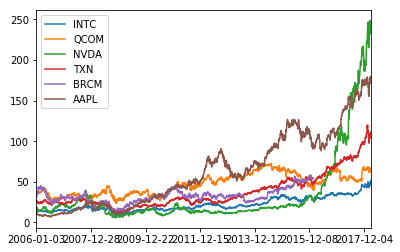

              INTC         QCOM         NVDA          TXN         BRCM  \
count  3065.000000  3065.000000  3066.000000  3066.000000  2536.000000   
mean     21.938068    46.929083    33.577374    37.395884    32.176194   
std       8.484741    12.784241    46.542018    21.256818     8.747484   
min       9.052754    23.535448     5.474608    11.253862    12.668263   
25%      15.542663    34.687172    12.823574    23.698014    26.874654   
50%      18.732004    47.538240    17.367189    28.019929    31.272215   
75%      29.006603    57.085907    23.911975    47.752630    36.029589   
max      52.190000    72.674180   249.080000   120.000000    58.320000   

              AAPL  
count  3065.000000  
mean     62.727955  
std      45.780656  
min       6.511801  
25%      21.252350  
50%      54.284287  
75%      96.692834  
max     179.980000  


In [1]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import capstone_support as cs

stocks = ["INTC", "QCOM", "NVDA", "TXN", "BRCM", "AAPL"]
# download data to local from quandl
# use stockstats https://github.com/jealous/stockstats to record few important
# stats about each of the stocks
cs.download_data(stocks)
# Get Adj.Close of every stock to plot
adj_close_df = cs.get_stocks_df_by_column(stocks)
adj_close_df.plot()
plt.show()
print(adj_close_df.describe())

The graph above shows a good description about how each of our stocks behaved. In terms of the closing price of each stock, we see that there is significant differences between the stocks. NVDA clearly shows a significant change in stock prices during the 2006-2018 period (77% of data is the 4th quartile). However, the closing prices themselves donot help much in understanding trends. We should rather use percentage change to understand stock behavior. Plotted below is a box-plot and a density plot to describe day-on-day percentage change for the 6 stocks.

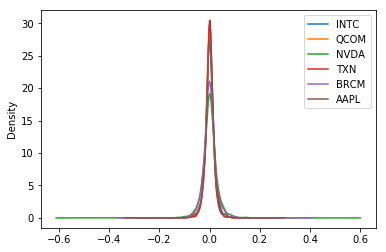

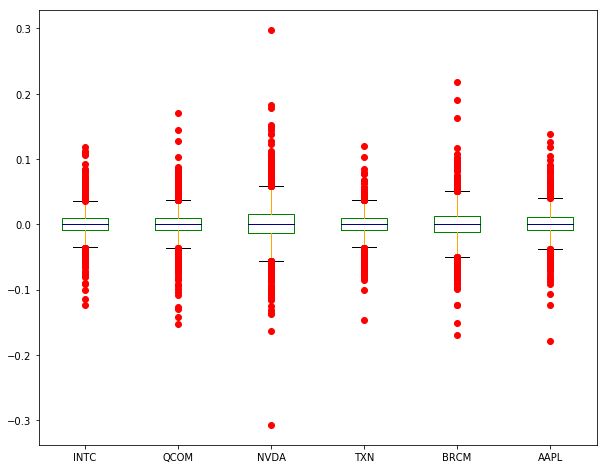

In [2]:
plt.close('all')
pct_change_df = adj_close_df.pct_change()
# plot density plt to see the distribution
pct_change_df.plot.kde()

# a box plot
color = dict(boxes='green', whiskers='orange', medians='DarkBlue', caps='Black')
pct_change_df.plot.box(figsize=(10,8), color=color, sym='ro')

plt.show()

The general trend of all the stocks seems to be in the 1st or the 4th quartile. It clearly shows that the period between 2006 and 2018 had resulted in significant changes in each of the stocks. There are a few obvious steep changes in closing price for NVDA, BRCM seems to be the only outlier in the data.

The correlation matrix plotted below shows that there is not significant correlation between the different stock prices. (Note: A low value means there is very low correlation). The most seems to be between TXN and INTC but even there it is about 66%. This implies that we should be attempting to model each stock independently. We will create models seperately for each stock and hope to predict close prices based on the trained model.

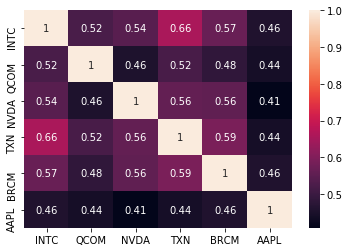

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

corrdata = pct_change_df.corr()

sb.heatmap(corrdata,
            xticklabels=corrdata.columns.values,
            yticklabels=corrdata.columns.values,
          annot=True)
plt.show()

### More input features:
Investment decisions are primarily based on fundamentals or technical analysis. Fundamental analysis use financial information about the company whereas technical analysis uses the stock/market information. Since we are using only the stock prices per-se, we will work on a few techical analysis that identify momentum or trends in a stock and see if the combination of a closing-price and these technical indicators help in predicting future stock prices. A few technical analysis used are:

#### Relative Strength Index (RSI):
RSI is a momentum oscillator i.e. it measures the rate of increase or decrease of stock prices over a period (typically 14 days) and essentially states if a stock is overbought (when above 70) or oversold (when below 30). RSI depends primarily uses the **closing ** price of a stock.
    
#### Average Directional Movement Index (ADMI):
ADMI is a trend indicator i.e. it basically measures the strength or weakness of a trend and hence provides a better judgement on when to enter and exit the market. ADMI also uses the **closing** price of a stock over a period (14-days typically) using either the observed postive or negative Directional Movement. Unlike RSI, it is a lagging indicator i.e. a trend is set before it can be observed.

#### Volatility Volume Ratio (VR):
VR is used to measure price range and is an indicator breakout or changes in the price range. It takes into account the change in **close** prices of a stock along with the **volume**  and calculated over a 26 day period.

#### Simple Moving Average (SMA):
Here we calculate the Simple moving average of **close** price of the stock over 14 days.

#### KDJ Stochastic Oscillator:
This is a stochastic osciallator that determines the undelying strength and direction by analyzing short term movements. It basically takes into account **close**, **high**, **low** and **range** of a stock price for a set period of time (typically 9 days).

The idea is to use the above indicators also as input features to a model and understand if these will help us better predict future stock prices.

Eyeballing the plots earlier, we can see that there is some interesting differences between NVDA and QCOM for the period 2016 onward. We can describe and plot these two stocks for the different indicators to look how they behave.

In [4]:
#sample_stocks = ['QCOM', 'NVDA']
close_df = cs.get_stocks_df_by_column(stocks, dateFrom = '2015-01-01')
print(close_df[['QCOM', 'NVDA']].describe())
rsi_df = cs.get_stocks_df_by_column(stocks, columnName = 'RSI', dateFrom = '2015-01-01')
admi_df = cs.get_stocks_df_by_column(stocks, columnName = 'ADMI', dateFrom = '2015-01-01')
vvr_df = cs.get_stocks_df_by_column(stocks, columnName = 'VVR', dateFrom = '2015-01-01')
sma_df = cs.get_stocks_df_by_column(stocks, columnName = 'SMA', dateFrom = '2015-01-01')
stoOsc_df = cs.get_stocks_df_by_column(stocks, columnName = 'StocOsci', dateFrom = '2015-01-01')

             QCOM        NVDA
count  800.000000  801.000000
mean    56.330814   84.428825
std      6.817818   68.637205
min     39.911677   18.588427
25%     51.149011   25.922422
50%     55.854338   56.861016
75%     63.010074  136.912052
max     68.670000  249.080000


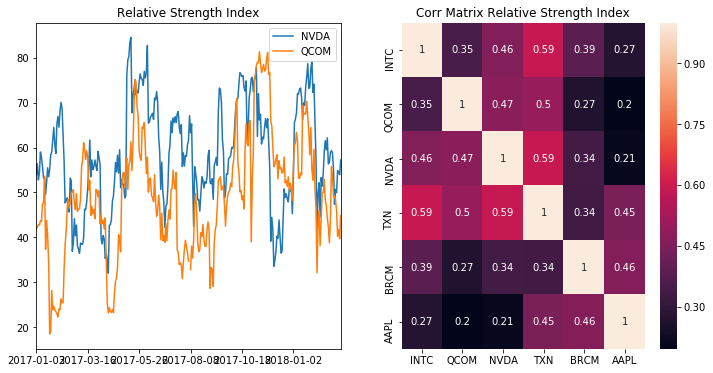

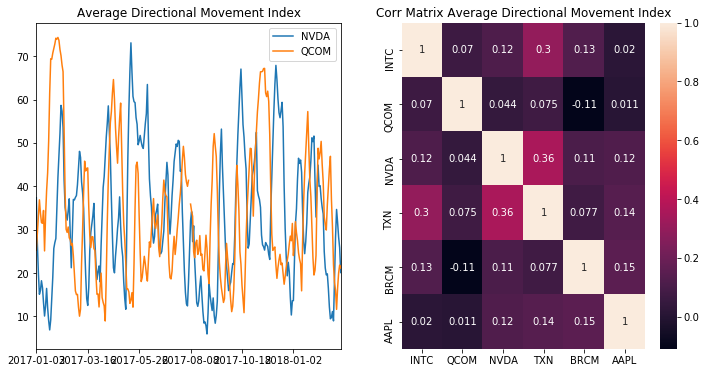

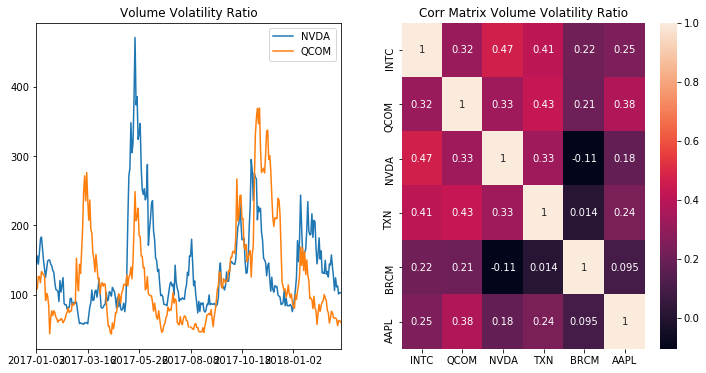

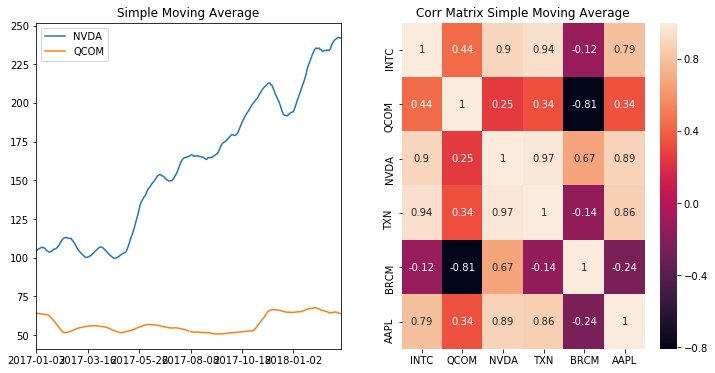

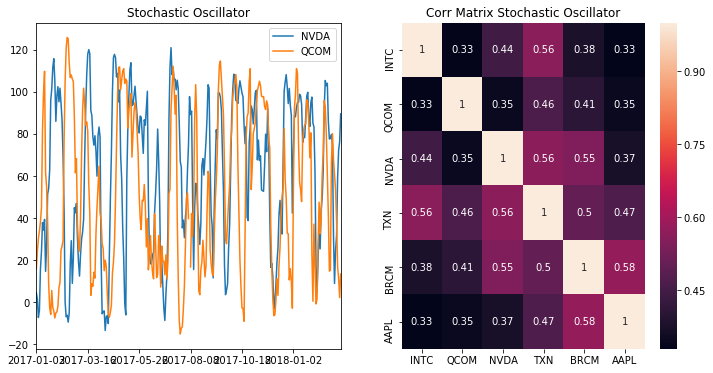

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

sample_stocks = ['NVDA', 'QCOM']
sample_stocks_from = '2017-01-01'
dataframeList = [rsi_df, admi_df, vvr_df, sma_df, stoOsc_df];
titleList = ['Relative Strength Index', 'Average Directional Movement Index', \
             'Volume Volatility Ratio', 'Simple Moving Average', 'Stochastic Oscillator']

plt.close('all')
for idx, frame in enumerate(dataframeList):
    fig, axis = plt.subplots(1,2, figsize=(12,6))
    corrdata = frame.corr()
    frame[sample_stocks][sample_stocks_from:].plot(ax=axis[0], title=titleList[idx])

    axis[1].set_title("Corr Matrix " + titleList[idx])
    sb.heatmap(corrdata,
                xticklabels=corrdata.columns.values,
                yticklabels=corrdata.columns.values,
                ax=axis[1], annot=True)
    plt.show()

The significant oscillations on the indicator for the sample stocks (NVDA & QCOM) is complemented by the correlation matrix which apart from SMA, shows that each of these indicators have very less correlation and therefore capture completely different characteristics of the stock. As a side, below is a correlation plot of the input space for a stock (here AAPL) - which unlike the original inputs (open,close,high,low,volume) - show very less correlation between one another indicating that the increase in input feature space with these indicators would be worth the extra computation.

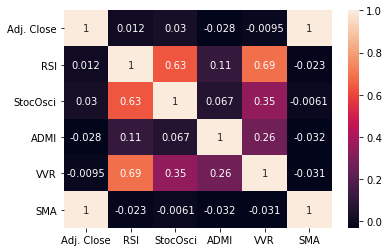

In [6]:
aapl_df = cs.get_stock_dataframe('AAPL')
#print(aapl_df.columns)
aapl_df.drop(['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume'], axis=1, inplace=True)
corrdata = aapl_df.corr()

sb.heatmap(corrdata,
            xticklabels=corrdata.columns.values,
            yticklabels=corrdata.columns.values,
          annot=True)
plt.show()

### Algorithms and Techniques

Stock market prediction is characterised as a time-series problem and hence we need to ensure that model evaluation is done without lookahead bias i.e. the test set a true test set and was never used in training. We will use Sklearn's TimeSeriesSplit to train using different ratios of train and test data. Additionally, we need to ensure that the event sequence is captured and hence we need to avoid randomizing the input samples.

The input feature space has values with different ranges. Hence we need to normalize the data so that learning will be done in a definite time and that the network will converge to a good minima. We will use MinMax scalar on the train and test sets.

The model will be evaluated using Root Mean Squared Error as this is essentially a regression problem (predict a stock close price in the future). With RMSE, a lower value indicates a better model. Evaluating the performance of a model for a timeseries problem is a bit tricky in that we would like to evaluate it based on its usage. TimeSeriesSplit can be used to generate multiple splits for example, 40/20, 60/20, 80/20 where we ensure test is done on 20% of the sample after the initial train sample. Note that data must not be shuffled so that we continue to maintain sequence. By testing on a constant sample size, we can aggregate the test result to know a more realistic performance of the model. 

A more realistic way to evaluate the model is by using a rolling forecast or walk-forward validation. In real world usecase, we are more interested in predicting using an online-model i.e. a model which is built on the most recent corpus of data. We decide on a set of samples to be used for training (like the most recent 60 days) and make a prediction for the next (or future) time. With new data, the model is retrained. This is repeated for as many samples required. Note that this would mean we would end up creating many models which is compute intensive.

Stock market prediction can take many forms. We can try to predict the closing-price or generate a buy/sell decision for the next day. However, based on tests i have done and looking at realistic usecases, prediction 1 day in advance is not very interesting. This is because stock-prices generally tend to vary very slightly day-on-day and so the model would choose to weigh the previous day's values more heavily than historical values. As a conclusion to this project, i will attempt to predict for 14 days in advance for the final LSTM model. However, as far as comparison between baseline and final model goes, i will still be using a 1 day prediction since that makes more sense for the baseline model.

### Benchmark Model

There are multiple ways to design a benchmar model. As part of this project, I would like to opt for two different benchmarks. The first benchmark model will simply predict the current day's closing-price for the next day. While this will perform very well it is not super useful. A 2nd benchmark model will predict closing-price using a simple moving average over past M days. The parameter M needs to be picked based on empirical tests and to some extent on domain knowledge. This is a very realistic benchmark model as stock prices vary ever so slightly on a daily basis. For this model, we are not doing any sort of training and hence we could potential avoid creating a train/test plit. However, doing so will not give an apple-to-apple comparison. Hence we still create a train/test split but use only the test data for evaluation purposes.

In [7]:
## HELPER FUNCTIONS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime

# The stock we are interested in
stock_name = "QCOM"
# Data set includes stock prices beginning at start_date
stock_start_date = '2006-01-01'
# Number of historical days (M) to use for the prediction
# In baseline model, this is used to generate the prediction
# In lstm, this is an input sequence
M_historical_days = 30
# Predict for N days ahead
N_predict_days = 14
# Splits to use for TimeSeriesSplit
timeSeriesSplitCount = 4
# random_seed initial value
random_seed = 515

np.random.seed(random_seed)

def rmse_score(predicted, true_label):
    return math.sqrt(mean_squared_error(true_label, predicted))

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

def prepareBaselineModelData(stock_data, m_days, n_days):
    df = pd.DataFrame()
    for i in range(m_days):
        closeCol = 'c' + str(i);
#         volCol = 'v' + str(i);
        df[closeCol] = stock_data.iloc[:]['Adj. Close'].shift(-i)
#         df[volCol] = stock_data.iloc[:]['Adj. Volume'].shift(-i)
    df['y'] = stock_data.iloc[:]['Adj. Close'].shift(-m_days) # predicting for next day
    #print(df[:10])
    df = df.dropna()
    #print(df.shape)
    return df

def predictBaselineModel(df, m_days, useAverage):
    # predict close as of last known or the mean of n_days
    result = df.drop(['y'], axis=1)
    if (useAverage is True):
        c_cols = []
        for i in range(m_days):
            c_cols.append('c' + str(i))
        result['y'] = df[c_cols].mean(axis=1)
    else:
        col = 'c' + str(m_days-1) # predict last known value
        # col = 'c' + str(1) # predict same days value
        result['y'] = df[:][col]        
    return result
    
def validateBaselineModel(ax, df, m_days, splits, dates, title, useAverage = True):
    tsSplit = TimeSeriesSplit(n_splits=splits)
    baseline_scores = []
    for train_index, test_index in tsSplit.split(df):
        trainScaler = MinMaxScaler(feature_range=(-1, 1))
        testScaler = MinMaxScaler(feature_range=(-1, 1))
        #print("Df shape {} Indexes Train {} Test {}".format(df.shape, len(train_index), len(test_index)))
        #train, test = df[0:len(train_index)], df[len(train_index):len(train_index)+len(test_index)]
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_scaled = trainScaler.fit_transform(train[df.columns])
        train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
        test_scaled = testScaler.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)
        test_dates = dates[len(train_index):len(train_index)+len(test_index)]
        #print("test_dates {} vs dates {}".format(test_dates.shape, dates.shape))

        actual = test_scaled
        predicted = predictBaselineModel(test_scaled, m_days, useAverage)
        y_pred = testScaler.inverse_transform(predicted)
        y_pred_df = pd.DataFrame(y_pred, columns=predicted.columns)
        y = testScaler.inverse_transform(actual)
        y_df = pd.DataFrame(y, columns=actual.columns)

        #print("Shapes of y_pred {} and y {}".format(y_pred_df['y'].shape, y_df['y'].shape))
        baseline_scores.append(rmse_score(y_pred_df['y'], y_df['y']))
        if (len(baseline_scores) == splits):
            cs.plot_graph(ax, test_dates, y_pred_df['y'], y_df['y'], title)

    #print(baseline_scores)
    return baseline_scores


def run_baseline(stock_data, split_count, M_history, N_predict):
    plt.close('all')
    num_baseline_types = 2
    fig, ax = plt.subplots(1, num_baseline_types, figsize=(14,8))
    temp_data = stock_data
    stock_frame = prepareBaselineModelData(temp_data, M_history, N_predict)
    stock_dates = stock_frame.index.values
    stock_frame = stock_frame.reset_index().drop(['Date'], axis=1)
    #print(stock_dates.shape)
    #print(stock_frame.shape)
    title1 = "Baseline model - Same day prediction"
    title2 = "Baseline model - SMA over {} days prediction".format(M_history)
    score1 = validateBaselineModel(ax[0], stock_frame, M_history, split_count, \
                                   stock_dates, title1, False)
    score2 = validateBaselineModel(ax[1], stock_frame, M_history, split_count, \
                                   stock_dates, title2, True)
    print("{} score : mean - {}".format(title1, np.mean(score1)))
    print("{} score : mean - {}".format(title2, np.mean(score2)))
    plt.show()


Test dates start 2015-08-26 end 2018-01-25
Test dates start 2015-08-26 end 2018-01-25
Baseline model - Same day prediction score : mean - 0.8824490229557594
Baseline model - SMA over 30 days prediction score : mean - 2.506997629710077


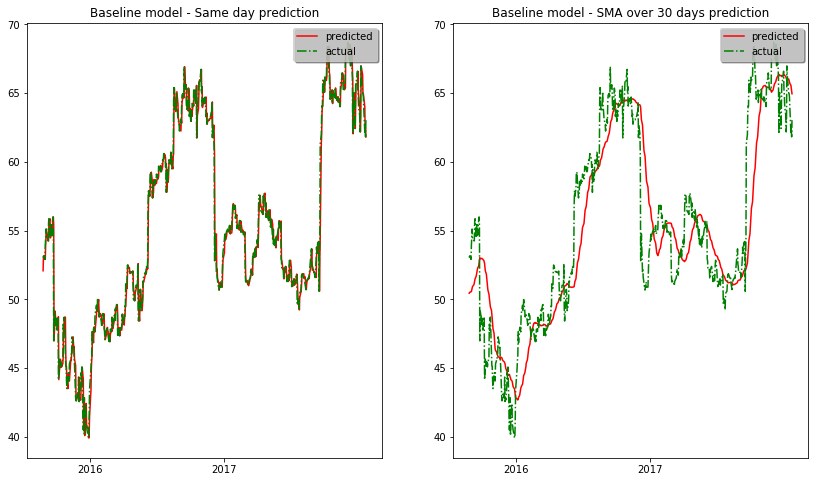

In [9]:
stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
run_baseline(stockdf, timeSeriesSplitCount, M_historical_days, N_predict_days)
# [2.60424767263038, 3.696717167358234] when y is considered with N_predict_days
# [1.3040513563033131, 1.8361952433433824] why y assumes next day prediction

As can be seen from the graph, the predictions follow the actual closing-price very closely for same day prediction while the SMA prediction follows it with a slight lag. It is clear that increasing SMA over a larger window would show a much more larger lag and poorer scores. For the record, these are the aggregated scores for the two baseline models:

**Baseline model Scores**

Same day prediction : 0.88

SMA over M historical days prediction : 2.50

There are essentially 2 main files used in this project and 1 another python notebook that carries the experimentation code

capstone_submission.ipynb - is this main file which documents the project and the various stages

capstone_support.py - is a helper python file that implements all utilies to download data from quandl, process it using 
stock_stats, save to csv, provide stock dataframes and plotting graphs.

capstone_parameter_tuning.ipynb - carries all the experimentation done on the LSTM model.

consolidated_exp.csv - result of parameter tuning done in capstone_parameter_tuning file

stock_data/\*.csv - contains downloaded data from quandl appended with stockstats [feel free to use this rather than downloading again]

### Data Preprocessing

We do have sufficient clearly marked data for stock prices as was downloaded from quandl. Further, we were able to pull out some useful statistics related to technical analysis of the stock. For a deep neural network to learn the weights and biases and to converge to a good local minima, we do need to convert the input data such that it is within a specific range. Since we are using a LSTM network and a default activation of tanh, i plan to normalize all the input data to a scale of (-1 to 1). Furthermore, we need to ensure that the scaling is done seperately for the train and test data set to mimic a real world use case. Since we are learning to predict a sequence using LSTM, there is a need to convert the data to a format that is useable by a LSTM network. The input layer of a LSTM expects data in 3 dimensions i.e. (num_samples, observation_for_m_timesteps, num_features). Num_samples is the number of samples/examples we will create, Each timestep includes one observation - so if we wish to use a sequence length of 14 days, num_timesteps will be the closing-prices for a stock for 14 days in a sequence. Num_features is the prediction for one time-step. In our case, this will be of length 1 since we are trying to predict 1 future value. The function *prepareLSTMdata* converts the dataset to feed into the LSTM network. Similarily, when we are using the Closing price along with the technical stats about the stock, the multiple variable input data to the lstm is created in function *prepareLSTMMultiVariateData*

### Implementation

As detailed in the data preprocessing step, we first scale the LSTM input data and then create the input to feed to the LSTM network. I use a stacked LSTM model here. The input of the LSTM is a 3D vector of shape (num_samples, timesteps, features) and the output is a 1 dimensional value that is the stock's closing price. Since we are using a stacked LSTM model, the 2nd layer LSTM needs to get a inputs in the form of a sequence. Hence we set the return_sequences flag in the first LSTM layer so that it returns a sequence that can be fed into the next layer.

#### Model tuning
The first step of the implementation was to identify the best parameters. While there is significant domain knowledge on stock market prediction, there are a few parameters i would like to choose just based on experiments. For example, how many historical dates to use, how far can we predict to get a decent accuracy. Many other parameters are specific to the model i.e. num of epochs to train on, should we use a stateful LSTM or not, what are the optimizers to use. All of these different combinations have been tried out in the capstone_parameter_tuning.ipynb. The results of this is then used to create the model on which we will validate and do the final prediction.

The results of the experiments is stored in the consolidated_exp.csv file. I used a TimeSeriesSplit of 4 and hence there will be 4 runs. The run that would be most interesting is the 4th run since it is trained on the most amount of data and the testing is done on the most recent data. The columns of this csv file are as follows:

**run_id** The run_id is labelled based on the different parameters that it was tuned for. The format is as below:

mHistory-nPredict-Stateful-NumNeurons-NumEpochs-LossFunction-Optimizer-BatchSize

where, 

    mHistory - Number of historical dates to use for evaluation
    nPredict - Number of days to predict into the future. Here it is set to 1 i.e. next day prediction
    Stateful - Is the model stateless or stateful. Was set to false during experimentation to save on run time as from previous experiments indicated stateful model performed better when using smaller batch_sizes.
    NumNeurons - Number of neurons to set for the LSTM model. Note that i have already decided it to be a stacked layer since my other experiments showed that a stacked layer did perform better.
    NumEpochs - How many epochs to train for to get a performant model
    LossFunction - What is the loss function to use. Since it is a regression model, tried out both Mean Average Error (mae) and Mean Squared Error (mse)
    Optimizer - The different keras based optimzers available to use. 
    Batchsize - Size of a batch that is used for training

**run1** - LSTM model trained on 1/5 and tested on 2/5

**run2** - LSTM model trained on 2/5 and tested on 3/5

**run3** - LSTM model trained on 3/5 and tested on 4/5

**run4** - LSTM model trained on 4/5 and tested on 5/5

**runtime** - Time taken to train each model

Below is the results of the experiments. To pick a model that performed well but also within a reasonable amount of time, i ranked them by best_average_run (run_avg), best_run (run4) and best_time (runtime). A bar chart below is ranked based on best_run_rank. 14-False-30-30-mae-sgd-10 seems to have performed well (best_run_rank of 8, average_run_rank of 2 and time_taken_rank of 38. This is the only run in the top-10 whose time taken is within 50 percentile range.

         run_avg   best_run       runtime   avg_rank  best_rank  time_rank
count  88.000000  88.000000     88.000000  88.000000  88.000000  88.000000
mean    1.398412   1.629404   1294.014743  44.500000  44.500000  44.500000
std     0.453985   0.485859   2284.466820  25.547342  25.547342  25.547342
min     0.882626   1.000325     14.743600   1.000000   1.000000   1.000000
25%     1.034895   1.210494    253.824103  22.750000  22.750000  22.750000
50%     1.239004   1.483319    557.330080  44.500000  44.500000  44.500000
75%     1.691283   2.034357   1419.294308  66.250000  66.250000  66.250000
max     2.803473   2.953623  16388.323750  88.000000  88.000000  88.000000
                             run_avg  best_run      runtime  avg_rank  \
run_id                                                                  
30-False-30-10-mae-sgd-1    0.945391  1.000325  1799.574985      11.0   
30-False-5-30-mae-sgd-1     0.959429  1.006807  4015.189805      12.0   
30-False-30-30-mae-adam-10  0.910

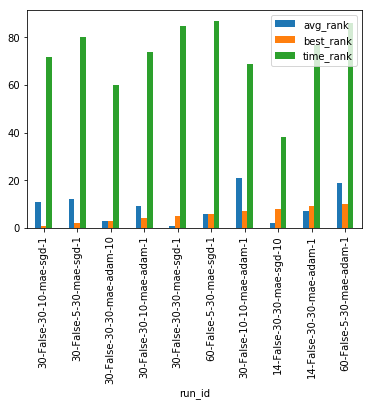

In [10]:
## Cell to evaluate metrics used
import pandas as pd
import matplotlib.pyplot as plt

experiment_results = pd.read_csv("consolidated_exp.csv", header=0)
experiment_results.set_index('run_id', inplace=True)
aggregated_df = pd.DataFrame()
aggregated_df['run_avg'] = experiment_results[['run1', 'run2', 'run3', 'run4']].mean(axis=1)
aggregated_df['best_run'] = experiment_results['run4']
aggregated_df = pd.concat([aggregated_df, experiment_results['runtime']], axis=1)#.divide(200)], axis=1)
aggregated_df['avg_rank'] = aggregated_df['run_avg'].rank(method='min')
aggregated_df['best_rank'] = aggregated_df['best_run'].rank(method='min')
aggregated_df['time_rank'] = aggregated_df['runtime'].rank(method='min')

print(aggregated_df.describe())
dfplot = aggregated_df.sort_values(['best_rank'], axis=0, ascending=True)
print(dfplot[:10])
plt.close('all')
plt.figure()
dfplot[['avg_rank', 'best_rank', 'time_rank']][:10].plot(kind='bar')
plt.show()

#### Implementation details:
There are 3 subsections that are covered in this implementation. They are:
a) Model Evaluation using next-day prediction
b) Single variable (closing-price) prediction for N days into the future
c) Multiple variable (closing-price and technical indicators) prediction for N days into the future


##### Model Evaluation using next-day prediction

A time-series evaluation cannot be done in the traditional sense of a deep neural network regression model since the sequence or order of events need to be maintained. To be able to evaluate the model, we will use the TimeSeriesSplit and use the train split for training while the test split is used for validation. Using a *timeSeriesSplitCount* of 4, we can simulate a 4 fold cross-validation setup as follows:

- Train on 1st fold and validate on 2nd fold
- Train on 1st and 2nd fold and validate on 3rd fold
- Train on 1st to 3rd fold and validate on 4th fold
- Train on 1st to 4th fold and validate on 5th fold

For model evaluation, the output value is the predicted closing-price for the next day. I have experimented using both a stateful and stateless model. While i noticed that the stateful model performed marginally better than the stateless one, the run time was extremely high. Hence for evaluation and final trained model purposes, i will use the stateless model. While using stateful model, the state of the model will be maintained across batch_sizes. Hence to reset the state after each epoch, we make  a call to model.reset_states().

The final evaluation is done on the validation set. While this may seem incorrect, I would like to use a test set that follows the trained sequence and the validation set is the most appropriate. Keeping a held-out data that is too far ahead from the training is also not the most approriate since we would then be testing on a sequence whose immediate prior data wasn't seen.

The following code and results are for the model evaluation. Please note that model evaluation takes a lot of time. Hence i have saved off the evaluation results in a .csv files that can be used to plot the data.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

# set a random seed to get consistent results across runs
np.random.seed(random_seed)
def rmse_metric(y, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y), axis=-1))

def prepareLSTMModelData(stockdf, timesteps):
    num_samples = stockdf.shape[0] - (timesteps)
    num_features = stockdf.shape[1]
    print(stockdf.shape)
    X = np.zeros((num_samples, timesteps, num_features))
    y = np.zeros((num_samples))
    
    for i in range(num_samples):
        y_pos = i + timesteps
        X[i] = stockdf[i:y_pos]
        y[i] = stockdf['Adj. Close'][y_pos]

    return (X, y)

def prepareMultiVariateLSTMModelData(stockdf, timesteps):
    return prepareLSTMModelData(stockdf, timesteps)

def createLSTMModel(X_train, m_days, n_days, \
        neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer, use_metric=False):
    model = Sequential()
    if (mStateFul == True):
        model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                return_sequences=True, \
                stateful=True, batch_size=mBatches))
    else:
        model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]),\
                   return_sequences=True))
    #model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(neurons))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    if (use_metric == True):
        model.compile(loss=lossFn, optimizer=modelOptimizer, metrics=[rmse_metric])
    else:
        model.compile(loss=rmse_metric, optimizer=modelOptimizer)
    print(model.summary())
    return model

def appendWithPrediction(lstm_input, prediction, m_days):
    for i in range(1, m_days):
        lstm_input[:, i-1, :] = lstm_input[:, i, :]
    lstm_input[:, m_days-1, :] = prediction
    return lstm_input

def score_prediction(model, scaler_test, X_test, y_test, m_days, n_days):
    print("X test {} and Y test {}".format(X_test.shape, y_test.shape))
    predicted = None
    for i in range(n_days):
        predicted = model.predict(X_test, batch_size=1)
        X_test = appendWithPrediction(X_test, predicted, m_days)
        print("Iter {} : new X test {}".format(i, X_test.shape))

    y_test = y_test.reshape(-1,1)
    print("Reshaped predicted {} and y_test {}".format(predicted.shape, y_test.shape))

    y_pred = scaler_test.inverse_transform(predicted)
    y_pred = y_pred[n_days:]
    y_pred_df = pd.DataFrame(y_pred, columns=["y_pred"])
    y_actual = scaler_test.inverse_transform(y_test)
    y_actual = y_actual[n_days:]
    y_actual_df = pd.DataFrame(y_actual, columns=["y"])

    score = rmse_score(y_pred_df['y_pred'], y_actual_df['y'])
    print(score)
    return score, y_pred, y_actual;

Using TensorFlow backend.


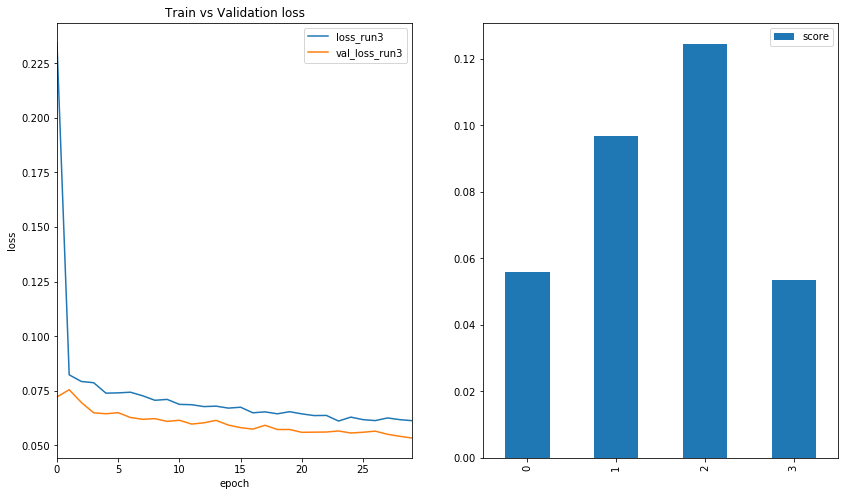

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from keras import backend
from sklearn.model_selection import TimeSeriesSplit
import os

class ModelHistory(Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        
    def on_batch_end(self, batch, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

#### cell with train-validation-test split
def appendWithPrediction(lstm_input, prediction, m_days):
    for i in range(1, m_days):
        lstm_input[:, i-1, :] = lstm_input[:, i, :]
    lstm_input[:, m_days-1, :] = prediction
    return lstm_input

def plot_train_validation(ax, train_stat, val_stat, title, y_label):
    ax.plot(train_stat)
    ax.plot(val_stat)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'validation'], loc='upper right')

def plot_all_train_validation(axPlot, frame, title):
    axPlot.set_title(title)
    axPlot.set_ylabel('loss')
    axPlot.set_xlabel('epoch')
    frame.plot(ax=axPlot)

def evaluateLSTMModel(scorePrediction, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    scaler_test = MinMaxScaler(feature_range=(-1, 1))
    df = df.reset_index().drop(['Date'], axis=1)
    split = 0.8
    if (scorePrediction == False):
        split = 1
    train_test_split = int(df.shape[0] * split)
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_scaled = None
    test_dates = None
    X_test, y_test = None, None
    if (scorePrediction == True):
        test_scaled = scaler_test.fit_transform(test[df.columns])
        test_scaled = pd.DataFrame(test_scaled, columns=df.columns)
        test_dates = dates[train_test_split+m_days:]
        X_test, y_test = prepareLSTMModelData(test_scaled, m_days)

    model_history_list = []
    score_list = []
    tsSplit = TimeSeriesSplit(n_splits=splits)
    for train_index, validation_index in tsSplit.split(train_scaled):
        trainSet, validationSet = train_scaled.loc[train_index], train_scaled.loc[validation_index]
        validationSet.reset_index(inplace=True, drop=True)
        X_train, y_train = prepareLSTMModelData(trainSet, m_days)
        X_val, y_val =  prepareLSTMModelData(validationSet, m_days)
        model = createLSTMModel(X_train, m_days, n_days,\
                    neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer, True)
        history = None
        model_history = ModelHistory();
        for i in range(num_epochs):
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=1, batch_size=mBatches, callbacks=[model_history])
            model.reset_states()
        model_history_list += [model_history]
        if (scorePrediction == True):
            score, u, v = score_prediction(model, scaler_test, X_test, y_test, m_days, n_days)
            score_list += [score]
        else:
            loss, metric = model.evaluate(X_val, y_val, batch_size=mBatches)
            score_list += [metric]

    last_history = model_history_list[len(model_history_list)-1]
    plt.close('all')

    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    plot_train_validation(ax, last_history.train_losses, last_history.val_losses, "Train vs Validation loss", 'loss')
    plt.show()

    print(score_list)
    return score_list, model_history_list

def doModelEvaluation():
    stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
    stock_data = stockdf[['Adj. Close']]
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    return evaluateLSTMModel(False, stock_frame, 30, 1, timeSeriesSplitCount, stock_dates, 30, 30, 30, False)
    #return evaluateLSTMModel(False, stock_frame, 30, 1, 2, stock_dates, 2, 2, 15, False)
    #print("Mean = {} and best = {}".format(np.mean(score), score[len(score)-1]))

evaluation_history = "capstone_evaluation_history.csv"
evaluation_scores = "capstone_evaluation_scores.csv"
if os.path.exists(evaluation_history) == False or os.path.exists(evaluation_scores) == False:
    eval_score, eval_history = doModelEvaluation()
    eval_score_df = pd.DataFrame(eval_score, columns=['score'])
    eval_history_df = pd.DataFrame()
    for index, history in enumerate(eval_history):
        eval_history_df['loss_run'+str(index)] = history.train_losses
        eval_history_df['val_loss_run'+str(index)] = history.val_losses
    eval_score_df.to_csv(evaluation_scores)
    eval_history_df.to_csv(evaluation_history)

eval_score_df = pd.read_csv(evaluation_scores)
eval_history_df = pd.read_csv(evaluation_history)
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(14,8))
eval_history_df.drop(['Unnamed: 0'], axis=1, inplace=True)
eval_score_df.drop(['Unnamed: 0'], axis=1, inplace=True)
plot_all_train_validation(ax[0], eval_history_df[['loss_run3', 'val_loss_run3']], "Train vs Validation loss")
eval_score_df.plot(ax=ax[1], kind='bar')
plt.show()

##### Single variable (closing-price) prediction for N days into the future
While predicting a day ahead will result in a very good model, it isn't as interesting as if we can predict well into the future. Here we will try to make the prediction for N days into the future (N = 14) using a historical data of M days (M = 30). (N = 14 was our objective and M was arrived at by experiments to find a good model that is developed in reasonable amount of time.)

The base implementation is similar to the code for Model evaluation. However, here we will use a TimeSeriesSplit of 2 to split the data into a train and test set only. The model is trained on the train set. We use a stateful stacked LSTM model as before. The test set is also created in the form of (num_samples, timesteps, num_features). The timesteps is essentially a matrix where the rows are a sequence. For a prediction using 30 days historical data, this is of shape 1x30. However, there is a subtle addition to be done inorder for the prediction to be done N days into the future. We use the model to make the next day prediction and then feed this prediction as a next time step in the sequence. In doing so we also drop the earliest timestep i.e. the zeroth one. We repeat this for N times to get the prediction for the Nth day, see *appendWithPrediction*.

Below is the full code and a graph that plots the prediction vs the actual values

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2131, 14, 1) and Y train (2131,)
Test dates (906,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2131/2131 [==============================] - 3s - loss: 0.2862       

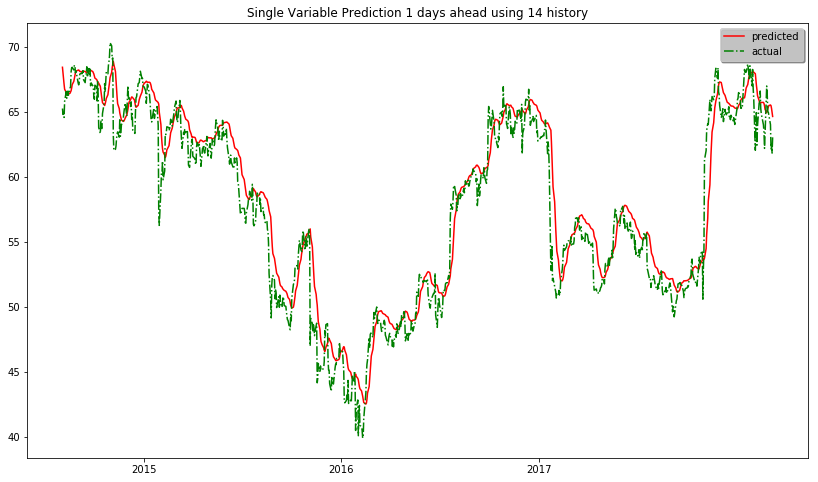

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2115, 30, 1) and Y train (2115,)
Test dates (890,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2115/2115 [==============================] - 5s - loss: 0.3616       

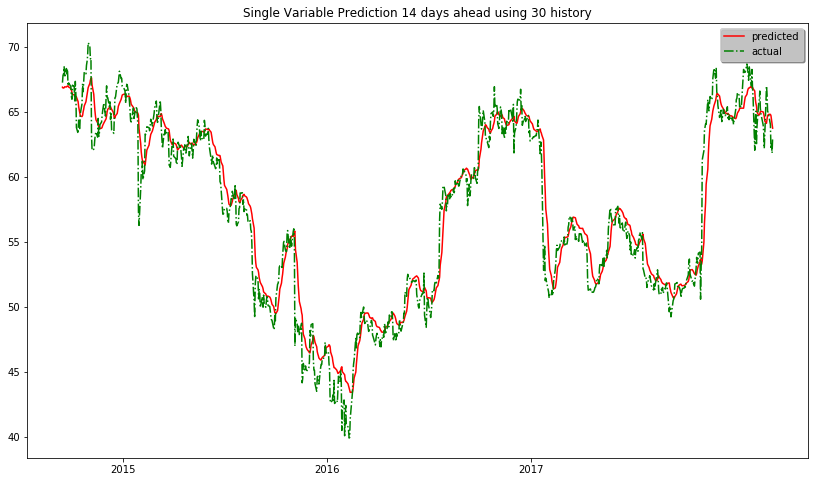

Train (2145, 1) and test (920, 1)
(2145, 1)
X train (2085, 60, 1) and Y train (2085,)
Test dates (860,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 30)            3840      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 11,191.0
Trainable params: 11,191.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2085/2085 [==============================] - 9s - loss: 0.2500       

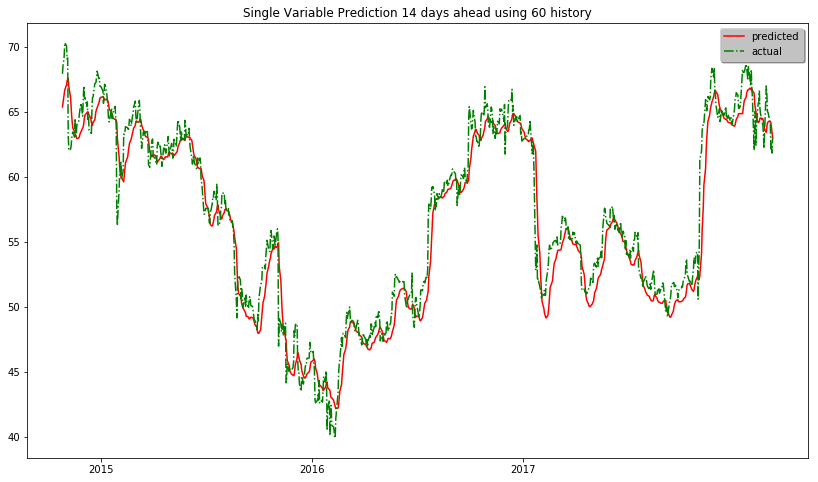

Model2 Scores: 2.022714619125958 1.719829179256257 1.7212851423760063


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

np.random.seed(random_seed)

def predictOnLSTMModel(ax, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    scaler_test = MinMaxScaler(feature_range=(-1, 1))
    train_test_split = int(df.shape[0] * 0.7)
    df = df.reset_index().drop(['Date'], axis=1)
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_scaled = scaler_test.fit_transform(test[df.columns])
    test_scaled = pd.DataFrame(test_scaled, columns=df.columns)

    X_train, y_train = prepareLSTMModelData(train_scaled, m_days)
    test_dates = dates[train_test_split+m_days:]

    print("X train {} and Y train {}".format(X_train.shape, y_train.shape))
    print("Test dates {}".format(test_dates.shape))
    model = createLSTMModel(X_train, m_days, n_days, neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer)
    history = None
    for i in range(num_epochs):
        history = model.fit(X_train, y_train,
              epochs=1, batch_size=mBatches)
        model.reset_states()
    X_test, y_test = prepareLSTMModelData(test_scaled, m_days)
    score, y_pred, y_actual = score_prediction(model, scaler_test, X_test, y_test, m_days, n_days)
    test_dates = test_dates[n_days:]
    print("test_dates shape {} vs y_pred shape {} vs y_test shape {}" \
          .format(test_dates.shape, y_pred.shape, y_test.shape))

    if ax is not None:
        plotTitle = "Single Variable Prediction {} days ahead using {} history".format(n_days, m_days)
        cs.plot_graph(ax, test_dates, y_pred, y_actual, plotTitle)

    print(score)
    return score

def doPrediction(stock_data, split_count, M_history, N_predict, useStateFul):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    score = 0
    if (useStateFul == False):
        score = predictOnLSTMModel(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 30, False)
    else:
        score = predictOnLSTMModel(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 1, True)
    plt.show()
    return score


stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
stockdf = stockdf[['Adj. Close']]
model2_score_14_1 = doPrediction(stockdf, timeSeriesSplitCount, 14, 1, False)
model2_score_30_14 = doPrediction(stockdf, timeSeriesSplitCount, 30, 14, False)
model2_score_60_14 = doPrediction(stockdf, timeSeriesSplitCount, 60, 14, False)
print("Model2 Scores: {} {} {}".format(model2_score_14_1, model2_score_30_14, model2_score_60_14))
# hist, prediction = (14,1), (30,14), (60,14)
# 30 Neuron 10 epoch stateful=False batchSize=30
# Model2 Scores: 2.150373078447592 3.6261774352497205 4.4569342171863475
# 30 Neuron 10 epoch stateful=True batchSize=1
# Model2 Scores: 12.899480005238212 16.623138920633 16.20987984364619
# 1.2384187520666916 - stateful - 3 day ahead based on 14 days history
# 1.6742855050066732 - stateful - 3 days ahead based on 14 day history, neuron 30, epoch 30
# 2.2240594224919827 - stateful - 14 days ahead based on 30 days history, neuron 30, epoch 30
# 1.2277235772532544 - stateful - 14 days ahead based on 60 days history
# 3.9544332779218276 - stateful - 14 days ahead based on 30 days history

##### Multiple variable (closing-price and technical indicators) prediction for N days into the future

In the earlier model, we fed a timesteps that contains sequence of only the Closing-price. We can also try running the model using sequences of the closing-price and the technical indicators such as 'RSI', 'StocOsci', 'ADMI', 'VVR' and 'SMA'. These should be helpful as we noticed that there is very less correlation between the indicators (except for SMA) to the closing-price. Moreover, this information is also available at the current timestep. The major change from the previous implementation is related to the shape of the input to the LSTM model. The num_features in the 3 dimensional array for the Univariate model was of size 1 whereas for the multi-variate it is going to be 5 (closing-price, RSI, StocOsci, ADMI, VVR). The model is still trained to predict the closing-price. Similarily, we need to ensure the same shape is maintained on the test set as well. The below code runs the multi-variate model and plots a graph for the actual vs prediction N days into the future.

Index(['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'RSI', 'StocOsci', 'ADMI', 'VVR', 'SMA'],
      dtype='object')
Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2131, 14, 5) and Y train (2131,)
Test dates (906,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 14, 30)            4320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1


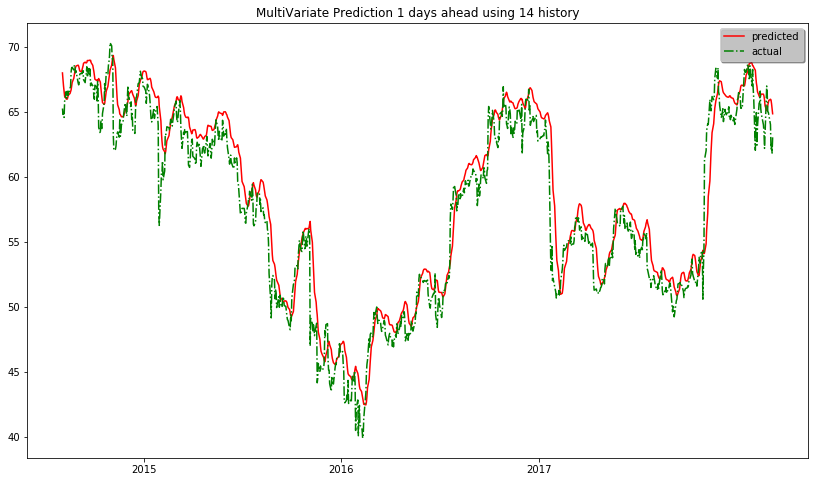

Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2115, 30, 5) and Y train (2115,)
Test dates (890,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 30)            4320      
_________________________________________________________________
lstm_16 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2115/2115 [==============================] - 6s - loss: 0.2333       

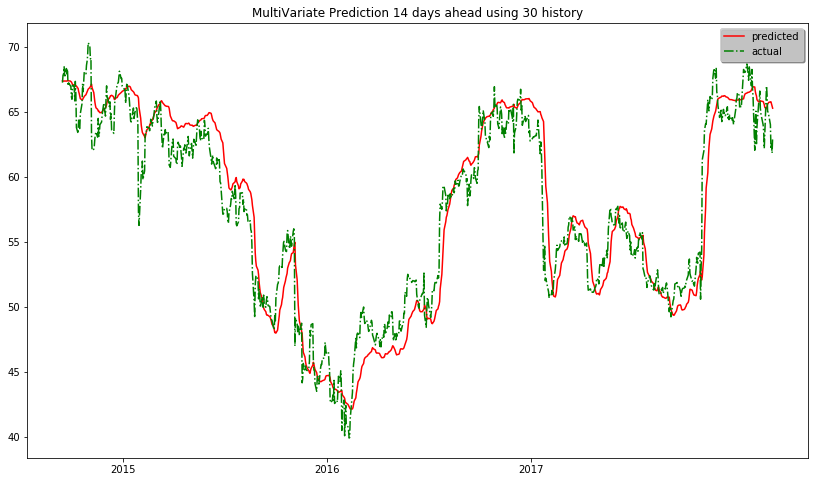

Train (2145, 5) and test (920, 5)
(2145, 5)
X train (2085, 60, 5) and Y train (2085,)
Test dates (860,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 60, 30)            4320      
_________________________________________________________________
lstm_18 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 11,671.0
Trainable params: 11,671.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/1
2085/2085 [==============================] - 8s - loss: 0.2166       

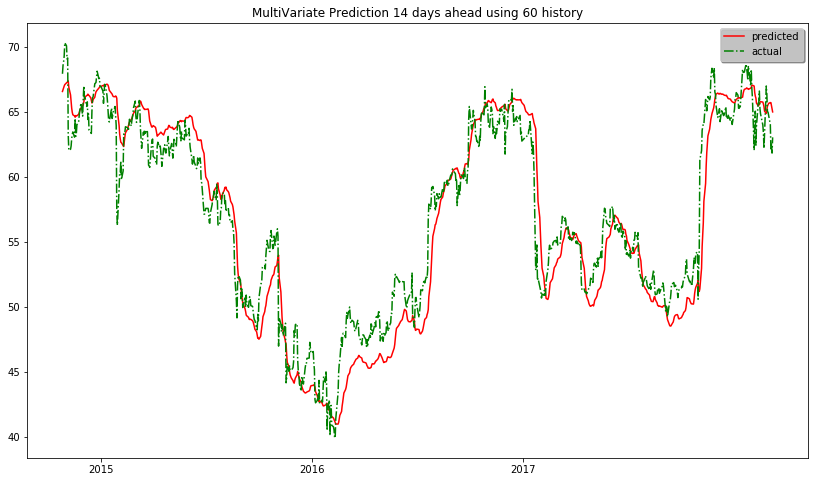

Model3 Scores: 2.0380514252722777 2.2413020772342427 2.3284990602489595


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras import backend

def predictMultiVariateLSTM(ax, df, m_days, n_days, splits, dates, \
                      neurons=20, num_epochs=1, mBatches=1, mStateFul=False, lossFn='mae', modelOptimizer='sgd'):
    scaler_train = MinMaxScaler(feature_range=(-1, 1))
    testInputScaler = MinMaxScaler(feature_range=(-1, 1))
    testPredictionScaler = MinMaxScaler(feature_range=(-1, 1))
    train_test_split = int(df.shape[0] * 0.7)
    df = df.reset_index().drop(['Date'], axis=1)
    train, test = df[0:train_test_split], df[train_test_split:]
    print("Train {} and test {}".format(train.shape, test.shape))
    train_scaled = scaler_train.fit_transform(train[df.columns])
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    test_input_scaled = testInputScaler.fit_transform(test[df.columns])
    test_input_scaled = pd.DataFrame(test_input_scaled, columns=df.columns)
    test_prediction_scaled = testPredictionScaler.fit_transform(test[['Adj. Close']])
    test_prediction_scaled = pd.DataFrame(test_prediction_scaled, columns=['Adj. Close'])

    X_train, y_train = prepareMultiVariateLSTMModelData(train_scaled, m_days)
    test_dates = dates[train_test_split+m_days:]

    print("X train {} and Y train {}".format(X_train.shape, y_train.shape))
    print("Test dates {}".format(test_dates.shape))
    model = createLSTMModel(X_train, m_days, n_days, neurons, num_epochs, mBatches, mStateFul, lossFn, modelOptimizer)
    history = None
    for i in range(num_epochs):
        history = model.fit(X_train, y_train,
              epochs=1, batch_size=mBatches)
        model.reset_states()
    X_test, y_test = prepareMultiVariateLSTMModelData(test_input_scaled, m_days)
    score, y_pred, y_actual = score_prediction(model, testPredictionScaler, X_test, y_test, m_days, n_days)
    test_dates = test_dates[n_days:]

    if ax is not None:
        plotTitle = "MultiVariate Prediction {} days ahead using {} history".format(n_days, m_days)
        cs.plot_graph(ax, test_dates, y_pred, y_actual, plotTitle)

    print(score)
    return score

def doMultiVariatePrediction(stock_data, split_count, M_history, N_predict, useStateFul):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(14,8))
    stock_frame = stock_data
    stock_dates = stock_frame.index.values
    score = 0
    if (useStateFul == False):
        score = predictMultiVariateLSTM(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 30, False)
    else:
        score = predictMultiVariateLSTM(ax, stock_frame, M_history, N_predict, split_count, stock_dates, 30, 30, 1, True)
    plt.show()
    return score

stockdf = cs.get_stock_dataframe(stock_name, dateFrom = stock_start_date)
print(stockdf.columns)
stockdf = stockdf[['Adj. Close', 'RSI', 'StocOsci', 'ADMI', 'VVR']]
model3_score_14_1 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 14, 1, False)
model3_score_30_14 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 30, 14, False)
model3_score_60_14 = doMultiVariatePrediction(stockdf, timeSeriesSplitCount, 60, 14, False)
print("Model3 Scores: {} {} {}".format(model3_score_14_1, model3_score_30_14, model3_score_60_14))
# hist, prediction = (14,1), (30,14), (60,14)
# 30 Neuron 10 epoch stateful=False batchSize=30
#Model3 Scores: 3.3747875396646627 2.5487346724593514 3.1695485500409295
# 30 Neuron 10 epoch stateful=True batchSize=1
#Model3 Scores: 11.81975415751083 15.555169356852309 16.410329557547918

#1.7034055157867667 - stateful=False, 14 day history to predict 3 days ahead, 20 neurons, 5 epochs
#1.3275506182291712 - stateful=True, 14 day history to predict 3 days ahead, 30 neurons, 30 epochs
#1.7820831662044965 - stateful=True, 14 day history to predict 3 days ahead, 20 neurons, 5 epochs
#2.7579731522527156 - stateful=True, 60 day history to predict 14 days ahead, 20 neurons, 5 epochs
#4.005008423523437 - stateful=True 30 day history to predict 14 days ahead, 20 neurons, 5 epochs

#### Complications

There has been multiple implementation challenges to getting here. A few listed in the order of complexity:
1. Training time
2. Creating the input data for LSTM model
3. Picking the right domain based parameters and model hyper parameters
4. Train test and validation for the LSTM model

The inputs for an LSTM model is very different from any other deep neural network models. I had to read up and experiment on the code to begin to understand how to structure the input data. Understanding this helped with the rest of the implementation process. The train/validation/test cycle is also different when working with time-series data sets. Once the basic implementation was done i had to contend with the different parameters that can be used to tune the model. I had to experiment with different parameters to begin to get a grasp of how to feed the data set. One of the more complicated parameters to wrestle with was the statefullnes of the model. When using stateful=True, we need to be able to set a batch_size that is appropriate for the input. This is so because the states are propogated to the next batch i.e. the state of the ith instance in batch N is propogated to the ith instance of batch N+1. Using a stateful model showed there was a better result compared to a stateless model though at the cost of much larger training time. The shuffle argument also had an impact on the model performance. While using a shuffle=False [which should be the case for stateful=True] scores better, i notice that it is not the same when using stateful=False. Training on both types of model (stateful set to True or False) was extremely slow on my personal computer but then running it on NVDIA GPUs on the cloud (Amazon EC2 p2.8xlarge) was also time consuming. As part of this project i have already generated the evaluations so that we don't have to regenerate them on all runs.


### Model Evaluation and Validation:

While we did evaluate across different train/validation set, i would say the evaluation of the model is best captured by the last train/validation split (since it captures all the sequences known and tests on the most recent known sequence). Model evaluation had been very tricky for this time-series problem since there were two major observations:

**When using a stateful model:**
I observed that there was the graph had extreme fluctuations validation loss between the different runs. If we train for very long, we do see that the training loss seems to be reducing over multiple epochs trained there are some exceptions, which is similar to the validation loss curves. This could be attributed to the fact that for the runs where the validation set is dissimilar to the training set the loss is higher and more representative validation set has lower loss. However, it is difficult to ascertain if the model has high variance (overfit) or high bias (underfit) or underfitting the data from the graphs.

**When using a stateless model:**
The train and validation loss graphed suggested that model had been improving over multiple iterations. Both train and validation loss reduced drastically till about epoch=3 and then continued to reduce at a much slower rate beyond epoch=5. It is clear that the model does not underfit the data. Conversely, we cannot say that the model overfits the data since the validation loss continues to reduce along with the training loss. [For an overfit model, we should be seeing the validation loss increase after the meeting point of the train and validation curves]. It is likely that running it for more iterations could give a better judgement call. Also having used shuffle=False may have allowed the model to generalize well for unseen cases. However, to conclude that it is a good fit may not be entirely true since we don't see the curves getting any closer. I think creating multiple feature inputs that can better model stock price would be a good addition to create a LSTM model that generalizes well for the input.

### Justification

While the model evaluation and validation seemed to be a dampner, we can see that the final two models that were used to predict for N days into the future showed that we can perform much better than the baseline model. 

Baseline - Predict using current day closing-price price: 0.88
Baseline - Predict using SMA of closing-price: 2.50
Model Evaluation - Predict using LSTM for next day based on 30-day: 0.05

| History   | Predict   | Univariate | MultiVariate |
|-----------|-----------|------------|--------------|
|    14     |    1      |   2.02     |    2.03      |
|    30     |    14     |   1.72     |    2.24      |
|    60     |    14     |   1.72     |    2.32      |


It is evident that we cannot reach the best baseline score - since this is predicting only a single day in advance. Our evaluated model which was configured to predict next day using 30 day history does show better scores (using the last fold of the validation set) indicating that the LSTM can perform as well as a baseline algorithm. I think the main reason why the evaluated model performs well is that unlike the best baseline model, it can use the sequence but also weigh heavily on the more recent values of the sequence.

However, a realistic usage begs us not to use a next day prediction and hence the two other LSTM models that were trained based on different historical dates and parameters. We see that the univariable LSTM model [model that used only sequences of closing-price] performs better than the SMA baseline algo even though it cannot match the next-day prediction baseline algo. I believe this is because it is behaving more like the SMA algo (the prediction line on the graph lags the actual value) but with better understanding of the sequence. It is a similar case with the multi variable LSTM model [model that uses both closing-prices and technical indicators in the input sequence]. It is interesting to see that the lag is more prominent in the multivariate LSTM model when the historical dates to use is increased. The score changes over usage of historical data and how far ahead to predict does make an important case i.e. stock market can be modeled and given more intelligent use of the data we should be able to get more accuracy.

### Improvements

Similar to providing technical analysis as inputs, we could also provide a stocks fundamentals as inputs. This would be an interesting case-study as it would consider the financial health of the company which is a strong indicator of how well it can perform in the future.
Unfortuantely, Stock markets are also driven by the human ideas and motivations - hence we would need to find a suitable way to provide this as inputs. Twitter feeds and news reports are a good source to model human motivations.
For an end-user, sometimes, the actual close-price may not be very useful compared to predicting stock decision labels such as buy / sell / hold. We can feed the output of the regression model into a classifier that can then predict these labels. On a more interesting note, we could create a hybrid model that feeds on the current developed model and a 2nd model that is modelled based on tweets, news, fundamentals and use the hybrid model to predict the label.


### Conclusion

We have been able to successfully create a deep neural network based model that can predict closing-price of a stock. We developed a baseline algorithm to compare against the final model. We used different techniques to identify good domain parameters and model hyper-parameters to achieve our objective. Graphical visualization tools were used to understand the input features and also the final output. One of the more interesting things i learnt in this project was that the approach to a sequence prediction problem seems very different from the other regression or cnn problems. From data preprocessing to model building to validation and testing, every step was completely different from what i had learnt during the course. One another aspect of the project which i found interesting was the use of technical indicators as the input. I wasn't sure how this would turn out especially considering that most technical indicators were derived from the closing-price of the stock itself. I was pleasantly surprised that a multi-variable LSTM does score as well or better than a uni-variate LSTM model. I am extremely thankful to the numerous research articles and blogs that helped me get to this point with my project.

##### References:

[1] 
http://snap.stanford.edu/class/cs224w-2015/projects_2015/Predicting_Stock_Movements_Using_Market_Correlation_Networks.pdf

[2] 
http://ieeexplore.ieee.org/document/7364089/

[3] https://etd.auburn.edu/bitstream/handle/10415/5652/Application%20of%20machine%20learning%20techniques%20for%20stock%20market%20prediction.pdf?sequence=2

[4]
https://arxiv.org/pdf/1801.04503.pdf

[5]
LSTM for house prices: https://arxiv.org/pdf/1709.08432v1.pdf

[6]
Stateful LSTM: philipperemy.github.io/keras-stateful-lstm/

[7]
Share prices and Random Walk : https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf

[8]
https://www.investopedia.com/university/technical/

[9]
http://www.binaryoptionsthatsuck.com/kdj-stochastic-indicator-can-you-improve-on-perfection/

[10]
Rolling forecast: https://www.otexts.org/fpp/2/5/

[11]
TimeSeries Validation: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

[12]
http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/
